# Google Play Store Applications Analysis
Source of the dataset: https://www.kaggle.com/datasets/bhavikjikadara/google-play-store-applications

## 1 Importing Libraries

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import (
    r2_score, explained_variance_score, f1_score, mean_absolute_error,
    mean_squared_error, accuracy_score, precision_score, recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')


## 2 Load the data

In [262]:
df = pd.read_csv(
    'dataset.csv',
    thousands=',',
    index_col=0,
)

## 3 Data Preprocessing
This may involve handling missing values, converting data types, or normalising
the data
### 3.1 Understanding the Data 

In [263]:
df.shape

(10841, 13)

In [264]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,7-Jan-18,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,1-Aug-18,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,8-Jun-18,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.2+ MB


In [266]:
df.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [267]:
categories=df['Category'].value_counts()
print(categories)

Category
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
1.9                       1
Name: count, dtype: int64


In [268]:
df['Installs'].value_counts()

Installs
1,000,000+        1579
10,000,000+       1252
100,000+          1169
10,000+           1054
1,000+             907
5,000,000+         752
100+               719
500,000+           539
50,000+            479
5,000+             477
100,000,000+       409
10+                386
500+               330
50,000,000+        289
50+                205
5+                  82
500,000,000+        72
1+                  67
1,000,000,000+      58
0+                  14
0                    1
Free                 1
Name: count, dtype: int64

In [269]:
df['Type'].value_counts()

Type
Free    10039
Paid      800
0           1
Name: count, dtype: int64

### 3.2 Fix shifted row

In [270]:
# It seems that in a certain row the data is shifted. Let's find out which row it is

bad_row_index=df.index[df['Category'] == '1.9'].tolist()[0]

"""
This row (10472) has no category and the other columns are shifted to the left...
It also has no 'Genre'
Should we add it to the category 'PHOTOGRAPHY'?
When the category is 'PHOTOGRAPHY', is the genre always 'Photography'?
"""

"\nThis row (10472) has no category and the other columns are shifted to the left...\nIt also has no 'Genre'\nShould we add it to the category 'PHOTOGRAPHY'?\nWhen the category is 'PHOTOGRAPHY', is the genre always 'Photography'?\n"

In [271]:
# When the category is 'PHOTOGRAPHY', is the genre always 'Photography'?

df_photography=df.loc[df['Category'] == 'PHOTOGRAPHY', ['Category', 'Genres']]
df_photography.loc[df_photography['Genres'] != 'Photography']

# Yes! So we could replace category with 'PHOTOGRAPHY' and  'Genres' with 'Photography'

,Category,Genres


In [272]:
row_to_shift=df.iloc[bad_row_index]
row_to_shift

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                          11-Feb-18
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [273]:
df.iloc[bad_row_index, 1:] = row_to_shift.shift(periods=1)[1:]
df.iloc[bad_row_index]

App               Life Made WI-Fi Touchscreen Photo Frame
Category          Life Made WI-Fi Touchscreen Photo Frame
Rating                                                1.9
Reviews                                              19.0
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                                    11-Feb-18
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [274]:
df.loc[bad_row_index,'Category'] = 'PHOTOGRAPHY'
df.loc[bad_row_index,'Genres'] = 'Photography'
df.iloc[bad_row_index]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                      PHOTOGRAPHY
Rating                                                1.9
Reviews                                              19.0
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                        Photography
Last Updated                                    11-Feb-18
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   App             10841 non-null  object
 1   Category        10841 non-null  object
 2   Rating          9367 non-null   object
 3   Reviews         10841 non-null  object
 4   Size            10841 non-null  object
 5   Installs        10841 non-null  object
 6   Type            10840 non-null  object
 7   Price           10841 non-null  object
 8   Content Rating  10841 non-null  object
 9   Genres          10841 non-null  object
 10  Last Updated    10841 non-null  object
 11  Current Ver     10833 non-null  object
 12  Android Ver     10839 non-null  object
dtypes: object(13)
memory usage: 1.4+ MB


### 3.3 Data Cleaning -> Changing the data types to numeric or date values and handling missing values
#### 3.3.1 Changing 'Rating' to numeric

In [276]:
# Checking that all rating are from [1, 5]
for i in df['Rating'].unique():
    i = float(i)
    if i < 1 or i > 5:
        print(i)
# There are none

In [277]:
def convert_to_numeric(x):
    num = None
    
    if isinstance(x, str):
        if ',' in x:
            x = x.replace(',', '')
        if '+' in x:
            x = x.replace('+', '')
        if '$' in x:
            x = x.replace('$', '')
        if "\"" in x:
            x = x.replace('\"', '')
        
        if 'M' in x:
            num =  float(x.replace('M', '')) * 10**6
        elif 'k' in x:
            num =  float(x.replace('k', '')) * 10**3
        elif '.' in x:
            num =  float(x)

        
        else:
            num =  float(x)

        return num
    
    return x

# Apply the function to the 'Rating' column
df['Rating'] = df['Rating'].apply(convert_to_numeric)

df['Rating'].describe()

count    9367.000000
mean        4.191513
std         0.515735
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

#### 3.3.2 Changing 'Reviews' to numeric

In [278]:
df['Reviews'] = df['Reviews'].astype(int)
df['Reviews'].describe()

count    1.084100e+04
mean     4.441119e+05
std      2.927629e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.476800e+04
max      7.815831e+07
Name: Reviews, dtype: float64

#### 3.3.2 Changing Size to numeric

In [279]:
df.replace({'Size': 'Varies with device'}, pd.NA, inplace=True)
df['Size'] = df['Size'].apply(convert_to_numeric)
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
df['Size'].describe()

count    9.146000e+03
mean     2.151450e+07
std      2.258834e+07
min      8.500000e+03
25%      4.900000e+06
50%      1.300000e+07
75%      3.000000e+07
max      1.000000e+08
Name: Size, dtype: float64

In [280]:
# We know that the size is in megabytes, so we can convert the size to megabytes
df['Size'] = df['Size'].apply(lambda x: x / 10**6)
df['Size'].describe()

count    9146.000000
mean       21.514505
std        22.588343
min         0.008500
25%         4.900000
50%        13.000000
75%        30.000000
max       100.000000
Name: Size, dtype: float64

#### 3.3.3 Changing Installs to numeric

In [281]:
df['Installs'] = df['Installs'].str.replace('+', '')
df['Installs'] = df['Installs'].str.replace(',', '')
df['Installs'] = df['Installs'].astype(int)
df['Installs'].describe()

count    1.084100e+04
mean     1.546291e+07
std      8.502557e+07
min      0.000000e+00
25%      1.000000e+03
50%      1.000000e+05
75%      5.000000e+06
max      1.000000e+09
Name: Installs, dtype: float64

#### 3.3.4 Changing Price to numeric

In [282]:
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)
df['Price'].describe()

count    10841.000000
mean         1.027273
std         15.948971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price, dtype: float64

#### 3.3.5 Changing Last Updated to date

In [283]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%d-%b-%y', errors="coerce")

#### 3.3.6 Deleting repeated rows

In [284]:
# Deleting repeated rows
df.drop_duplicates(inplace=True)

"""
There are still some apps that appear more than once so we will keep the one with the latest 'Last Updated' date
"""
# Sort the DataFrame by 'Last Updated' column in descending order
df.sort_values(by='Last Updated', ascending=False, inplace=True)

# Drop duplicates keeping only the first occurrence (since it's sorted in descending order)
df.drop_duplicates(subset='App', keep='first', inplace=True)

# If you want to reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)


#### 3.3.7 Checking if an app is free, its price should be 0

In [285]:
# Changing an app's 'Type' to 'Paid' if the price is greater than 0
# Replace 'Type' with 'Paid' where the price is greater than 0
df.loc[df['Price'] > 0, 'Type'] = 'Paid'

# Deleting the 'Type' column sinze it is no longer needed
df.drop(columns='Type', inplace=True)

#### 3.3.8 Handling missing values (Dropping rows with missing values)

In [286]:
# Drop rows with missing values
df.dropna(inplace=True)

### 3.4 Reviewing the data after cleaning

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7020 entries, 1 to 9659
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             7020 non-null   object        
 1   Category        7020 non-null   object        
 2   Rating          7020 non-null   float64       
 3   Reviews         7020 non-null   int64         
 4   Size            7020 non-null   float64       
 5   Installs        7020 non-null   int64         
 6   Price           7020 non-null   float64       
 7   Content Rating  7020 non-null   object        
 8   Genres          7020 non-null   object        
 9   Last Updated    7020 non-null   datetime64[ns]
 10  Current Ver     7020 non-null   object        
 11  Android Ver     7020 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 713.0+ KB


In [288]:
# For every column, get the value counts in descending order and take the index (value) of most common value
most_common = df.mode().iloc[0]
most_common

App                            #NAME?
Category                       FAMILY
Rating                            4.4
Reviews                           2.0
Size                             14.0
Installs                    1000000.0
Price                             0.0
Content Rating               Everyone
Genres                          Tools
Last Updated      2018-08-03 00:00:00
Current Ver                         1
Android Ver                4.1 and up
Name: 0, dtype: object

In [289]:
df.head(10)

,App,Category,Rating,Reviews,Size,Installs,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1,Shoot Hunter-Gun Killer,GAME,4.3,320334,27.0,50000000,0.00,Teen,Action,2018-08-08,1.1.2,4.1 and up
2,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,2.4,1000,7.99,Everyone,Health & Fitness,2018-08-08,1.9.3,4.2 and up
3,BankNordik,FINANCE,3.9,28,15.0,5000,0.00,Everyone,Finance,2018-08-08,7.3.2,5.0 and up
4,Video Downloader For FB: Save FB Videos 2018,TOOLS,4.3,434,3.6,50000,0.00,Everyone,Tools,2018-08-08,1.1.9,4.0.3 and up
5,Justice League Action Run,GAME,4.3,22333,9.7,1000000,0.00,Everyone 10+,Action,2018-08-07,2.01,4.3 and up
7,Monster Fishing 2018,SPORTS,4.4,32881,76.0,1000000,0.00,Everyone,Sports,2018-08-07,0.0.80,4.1 and up
9,Premier League - Official App,SPORTS,4.3,63782,24.0,5000000,0.00,Everyone,Sports,2018-08-07,1.1.5,4.1 and up
11,Masha and The Bear Jam Day Match 3 games for kids,FAMILY,4.6,50060,98.0,1000000,0.00,Everyone,Puzzle;Brain Games,2018-08-07,1.4.83,4.1 and up
13,FC Red Bull Salzburg App,SPORTS,4.5,1526,89.0,50000,0.00,Everyone,Sports,2018-08-07,4.0.4-R,5.0 and up
15,HipChat - beta version,COMMUNICATION,4.1,1035,20.0,50000,0.00,Everyone,Communication,2018-08-07,3.20.001,4.1 and up


### 3.5 Frequency Encoding for Categorical Variables

#### 3.5.1 Category

In [290]:
category_frequency_map: dict = df['Category'].value_counts(normalize=True).to_dict()

df['Category_FE'] = df['Category'].map(category_frequency_map)

#### 3.5.2 Content Rating

In [291]:
content_rating_frequency_map: dict = df['Content Rating'].value_counts(normalize=True).to_dict()
df['Content Rating_FE'] = df['Content Rating'].map(content_rating_frequency_map)

#### 3.5.3 Genres

In [292]:
genres_frequency_map: dict = df['Genres'].value_counts(normalize=True).to_dict()
df['Genres_FE'] = df['Genres'].map(genres_frequency_map)

## 4 Data Analysis

### 4.1 Descriptive Statistics


In [293]:
for col in df.select_dtypes(include='number').columns:
    print(f"{'='*30}\n{col.upper()}\n{'='*30}")
    print(f"{'Mean:':<20} {df[col].mean()}")
    print(f"{'Median:':<20} {df[col].median()}")
    print(f"{'Mode:':<20} {df[col].mode().iloc[0]}")
    print(f"{'Standard Deviation:':<20} {df[col].std()}")
    print()

RATING
Mean:                4.160413105413105
Median:              4.3
Mode:                4.4
Standard Deviation:  0.5595126410521235

REVIEWS
Mean:                145076.26994301996
Median:              1550.5
Mode:                2
Standard Deviation:  1024540.946614351

SIZE
Mean:                21.771773433048434
Median:              13.0
Mode:                14.0
Standard Deviation:  22.73207283552189

INSTALLS
Mean:                4478922.167806268
Median:              100000.0
Mode:                1000000
Standard Deviation:  27156392.213120084

PRICE
Mean:                1.171542735042735
Median:              0.0
Mode:                0.0
Standard Deviation:  18.20597837708227

CATEGORY_FE
Mean:                0.08427135331693734
Median:              0.03831908831908832
Mode:                0.21894586894586895
Standard Deviation:  0.07829416166462806

CONTENT RATING_FE
Mean:                0.6690685952224412
Median:              0.8084045584045584
Mode:                0.808404

In [294]:
# For every column if it is of data type object, print the value counts of the column
for col in df.select_dtypes(include='object').columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print()

Column: App
App
Shoot Hunter-Gun Killer                    1
Aster DM Healthcare                        1
boattheory.ch Full 2018                    1
Calculator with Percent (Free)             1
Nuke Em All                                1
                                          ..
My Child from eDziecko.pl                  1
Adivina el cantante de Trap y Reggaeton    1
Offroad drive : 4x4 driving game           1
Carrier Landings Pro                       1
FML F*ck my life + widget                  1
Name: count, Length: 7020, dtype: int64

Column: Category
Category
FAMILY                 1537
GAME                    818
TOOLS                   626
PERSONALIZATION         274
LIFESTYLE               269
MEDICAL                 266
FINANCE                 258
PRODUCTIVITY            223
SPORTS                  221
BUSINESS                221
PHOTOGRAPHY             205
HEALTH_AND_FITNESS      191
COMMUNICATION           189
SOCIAL                  156
NEWS_AND_MAGAZINES      154
SH

### 4.2 Data Visualisation

#### 4.2.1 Distribution of Ratings

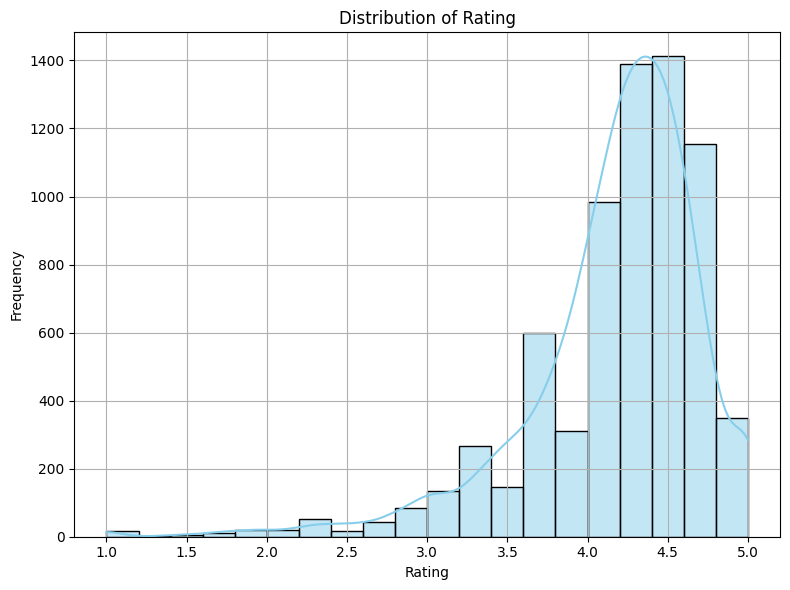

In [295]:
# Histogram of Rating
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue') # type: ignore
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

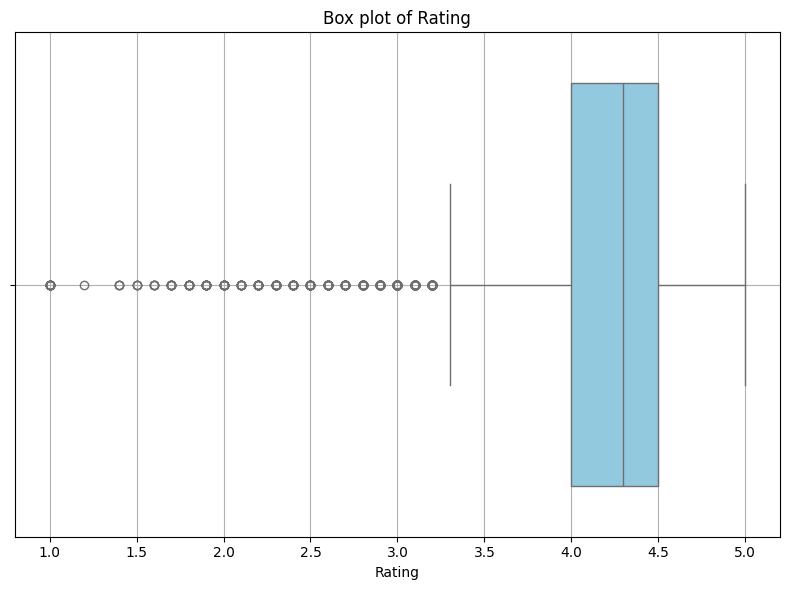

In [296]:
# Box plot of Rating
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Rating'], color='skyblue')
plt.xlabel('Rating')
plt.title('Box plot of Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.2.2 Distribution of Reviews

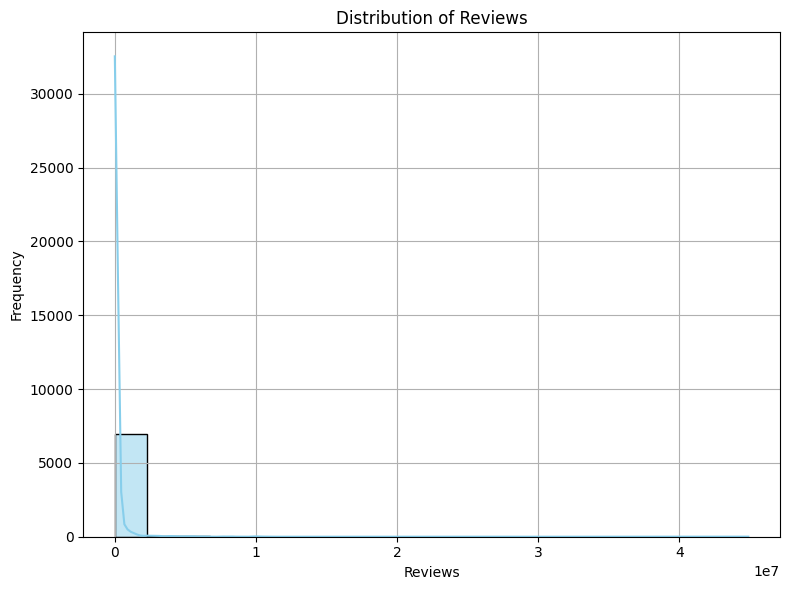

In [297]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Reviews'], bins=20, kde=True, color='skyblue') # type: ignore
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()

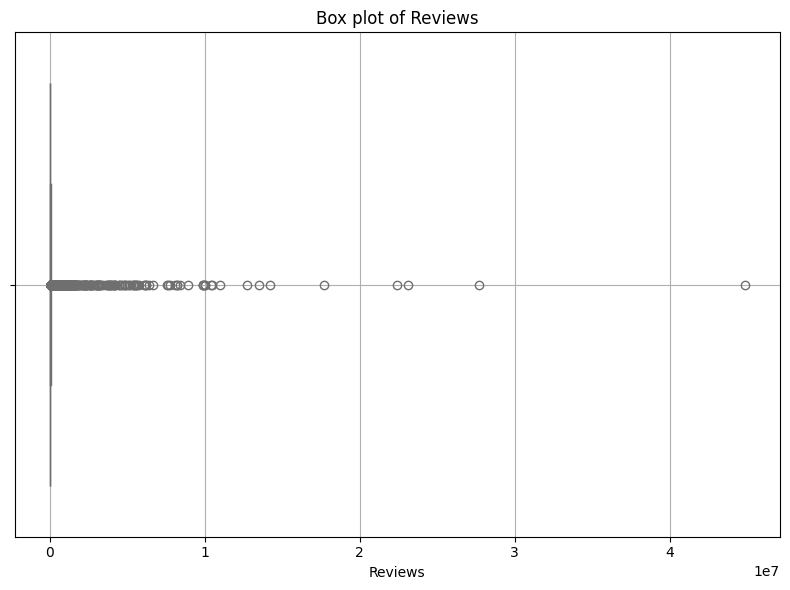

In [298]:
# Box plot of Reviews
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Reviews'], color='skyblue')
plt.xlabel('Reviews')
plt.title('Box plot of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.2.3 Distribution of Size

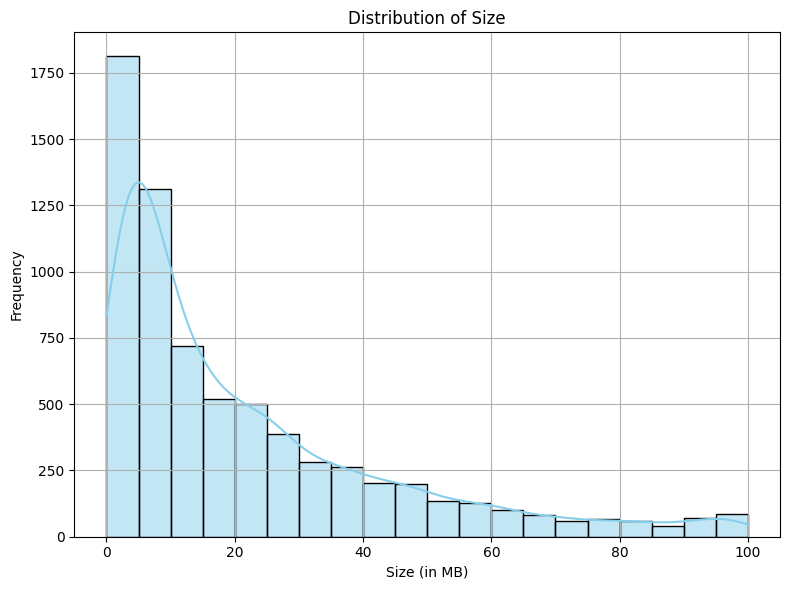

In [299]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Size'], bins=20, kde=True, color='skyblue') # type: ignore
plt.xlabel('Size (in MB)')
plt.ylabel('Frequency')
plt.title('Distribution of Size')
plt.grid(True)
plt.tight_layout()
plt.show()

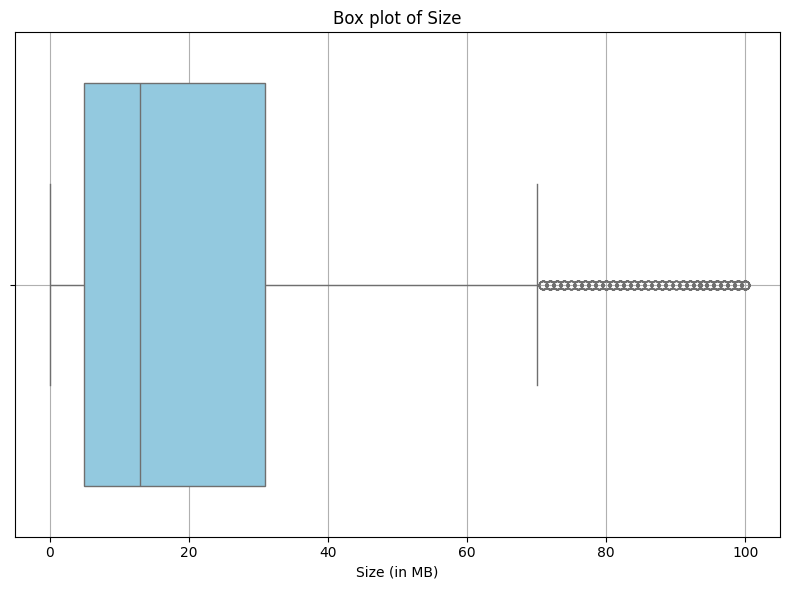

In [300]:
# Box plot of Size
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Size'], color='skyblue')
plt.xlabel('Size (in MB)')
plt.title('Box plot of Size')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.2.4 Distribution of Installs

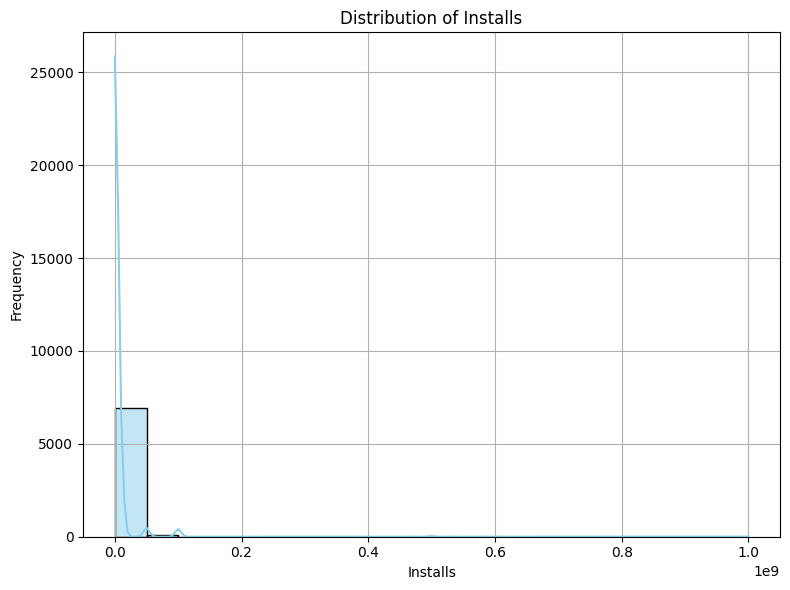

In [301]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Installs'], bins=20, kde=True, color='skyblue') # type: ignore
plt.xlabel('Installs')
plt.ylabel('Frequency')
plt.title('Distribution of Installs')
plt.grid(True)
plt.tight_layout()
plt.show()

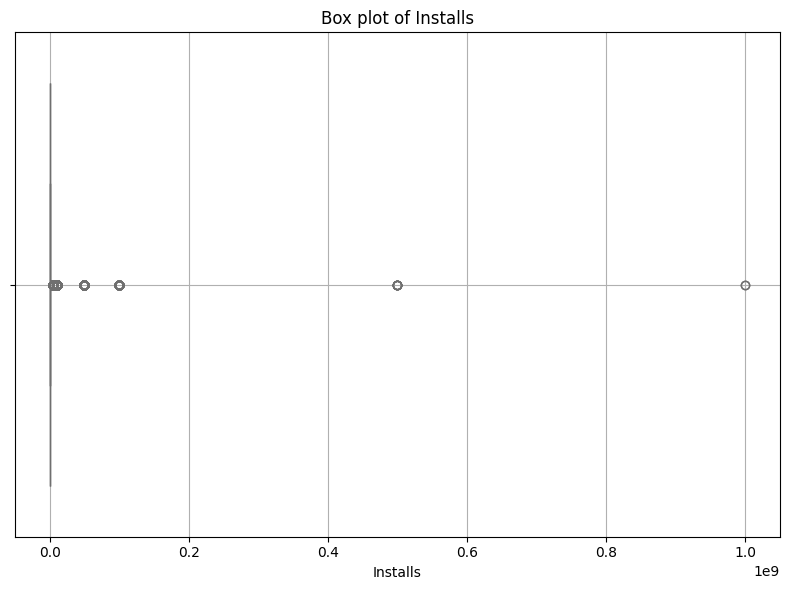

In [302]:
# Box plot of Installs
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Installs'], color='skyblue')
plt.xlabel('Installs')
plt.title('Box plot of Installs')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.2.5 Distribution of Price

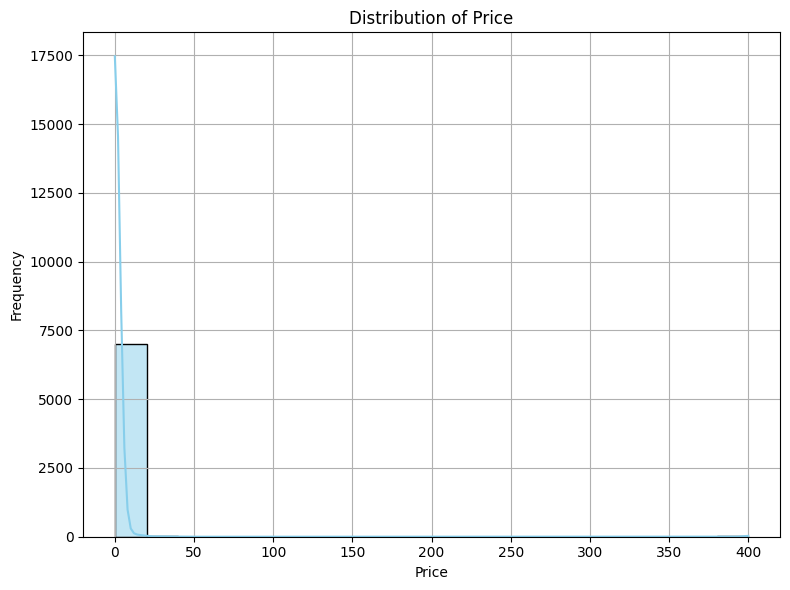

In [303]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], bins=20, kde=True, color='skyblue') # type: ignore
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.grid(True)
plt.tight_layout()
plt.show()

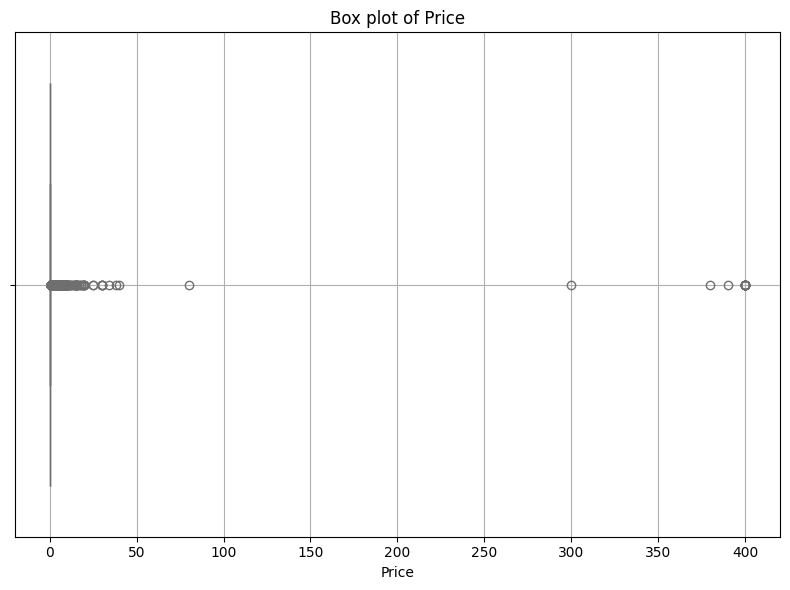

In [304]:
# Box plot of Price
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Price'], color='skyblue')
plt.xlabel('Price')
plt.title('Box plot of Price')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.2.6 Visualisation of categorical variables

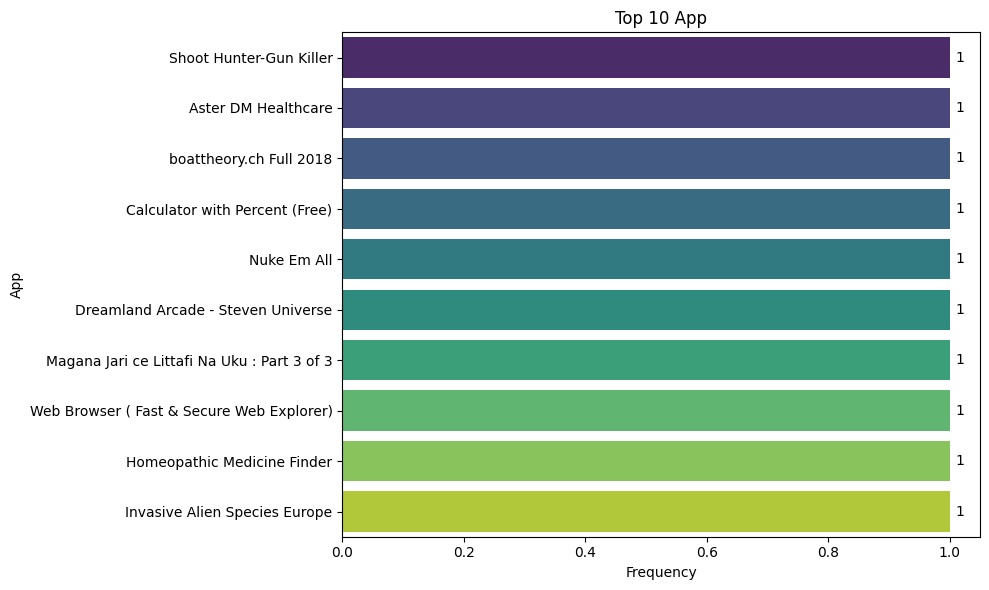

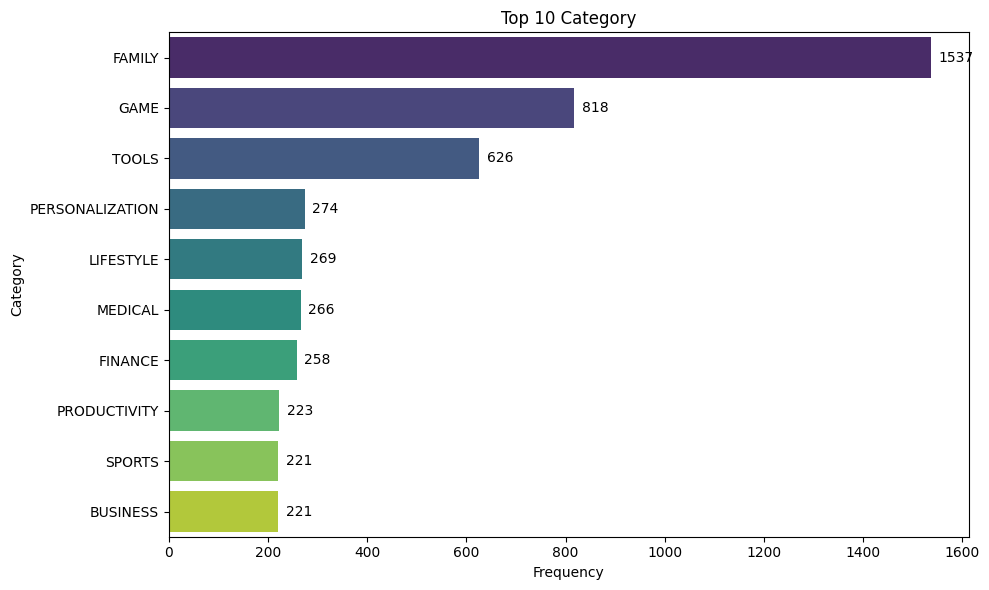

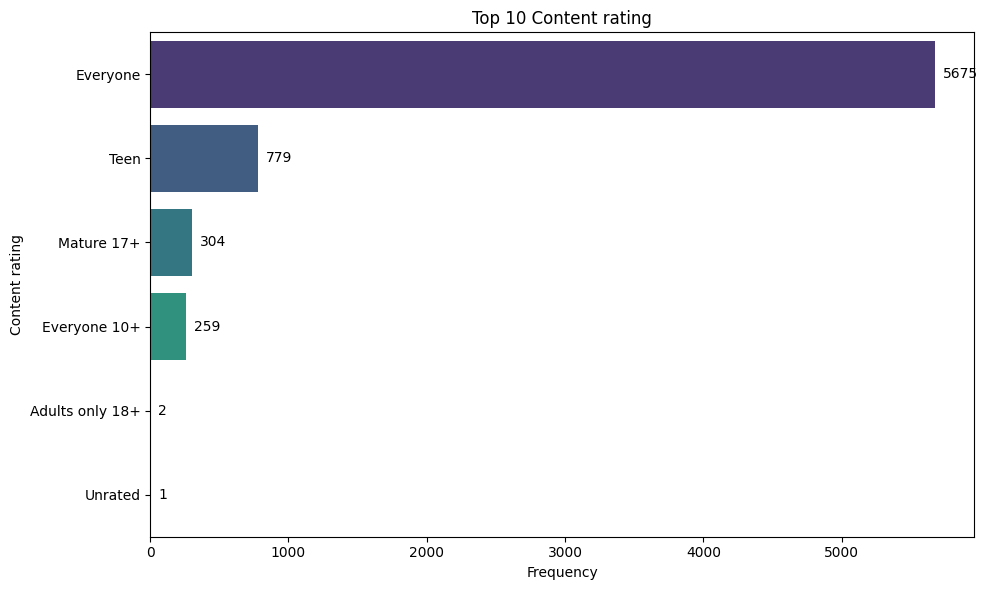

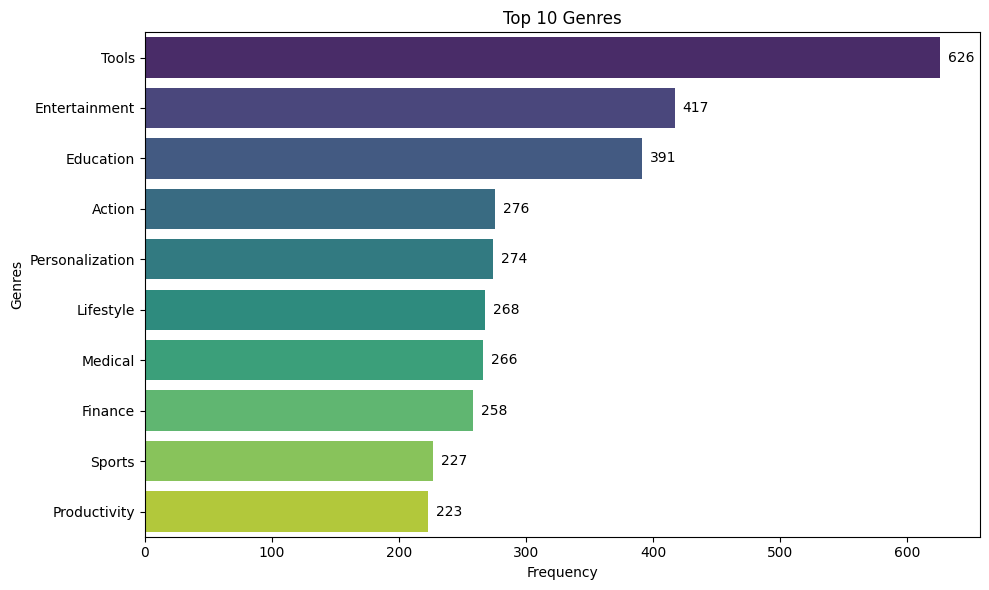

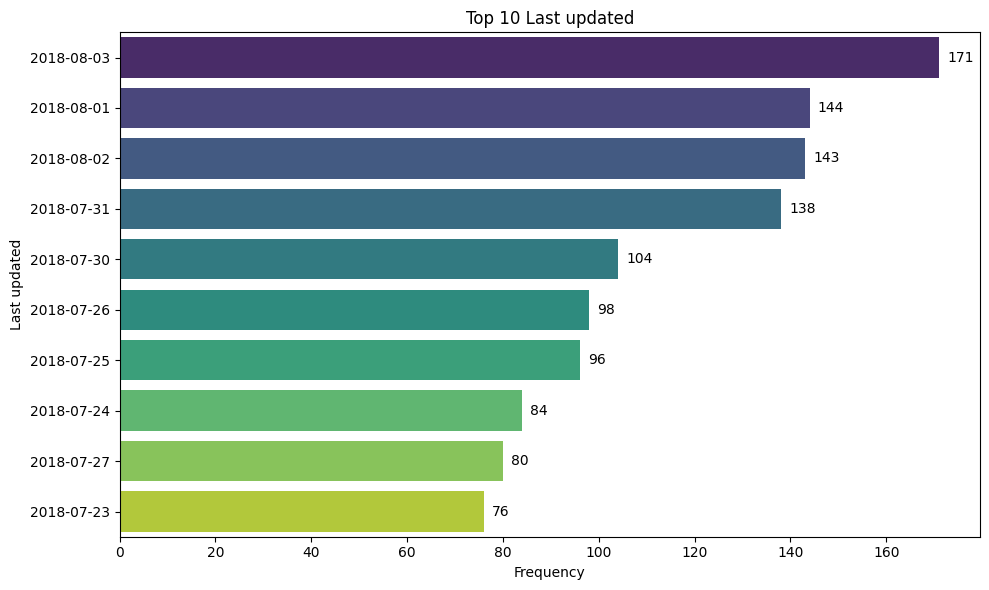

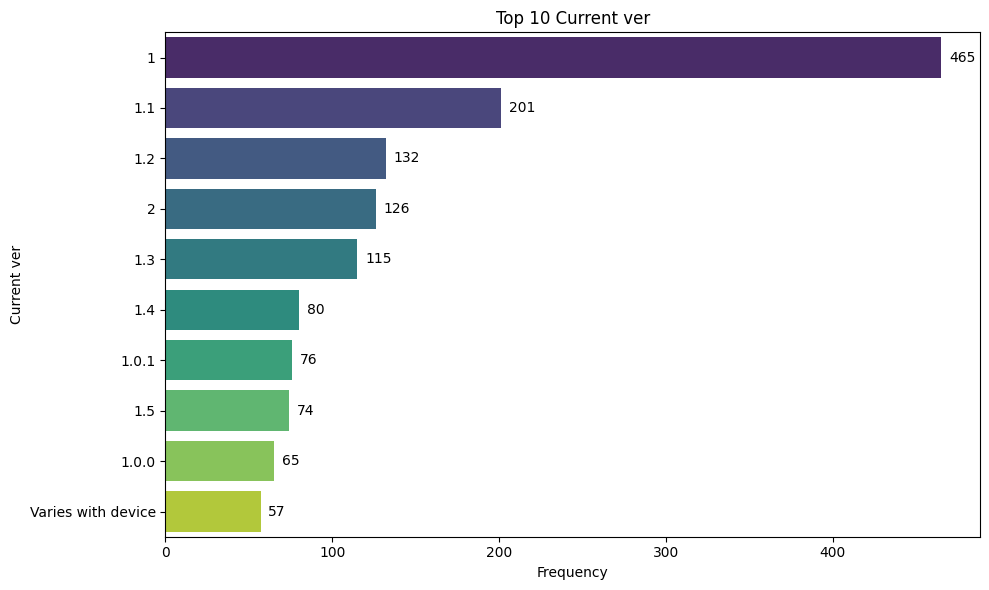

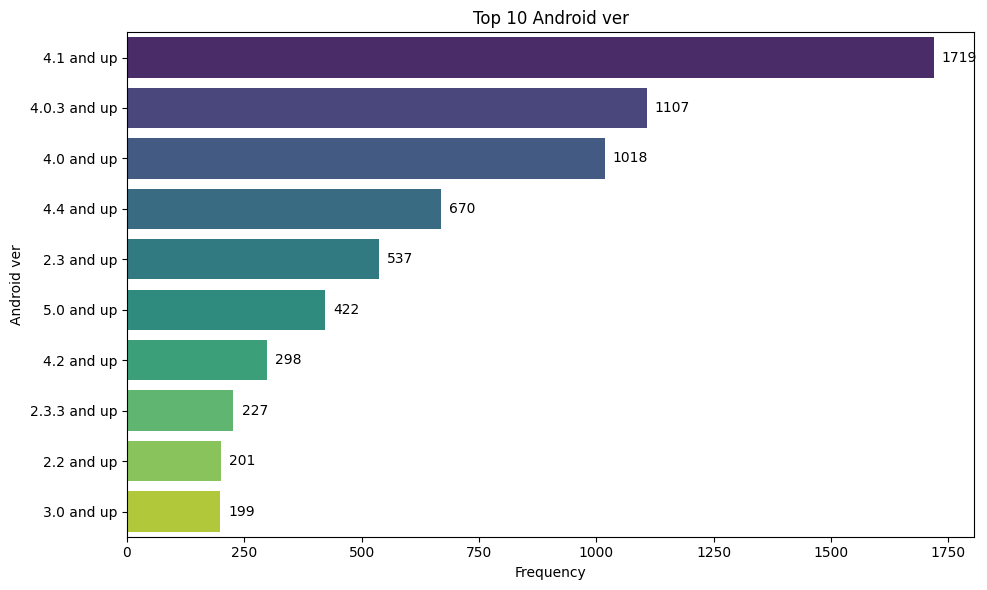

In [305]:
non_numeric_columns = df.select_dtypes(exclude='number').columns

# Loop through non-numeric columns and create count plots for the top 10 most frequent values
for col in non_numeric_columns:
    top_10_values = df[col].value_counts().nlargest(10)  # Get the top 10 most frequent values
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    ax = sns.barplot(x=top_10_values.values, y=top_10_values.index, palette='viridis', ci=None)  # Create a bar plot with seaborn, ci=None to remove confidence intervals
    plt.xlabel('Frequency')  # Add x-axis label
    plt.ylabel(col.capitalize())  # Add y-axis label with capitalized column name
    plt.title(f'Top 10 {col.capitalize()}')  # Add a descriptive title

    # Annotate each bar with its value
    for i, v in enumerate(top_10_values.values):
        ax.text(v + max(top_10_values.values) * 0.01, i, str(v), color='black', va='center')  # Adjust position of the annotation relative to the bar width

    plt.tight_layout()  # Adjust layout to prevent overlapping elements
    plt.show()


## 4.3 Playing with the data

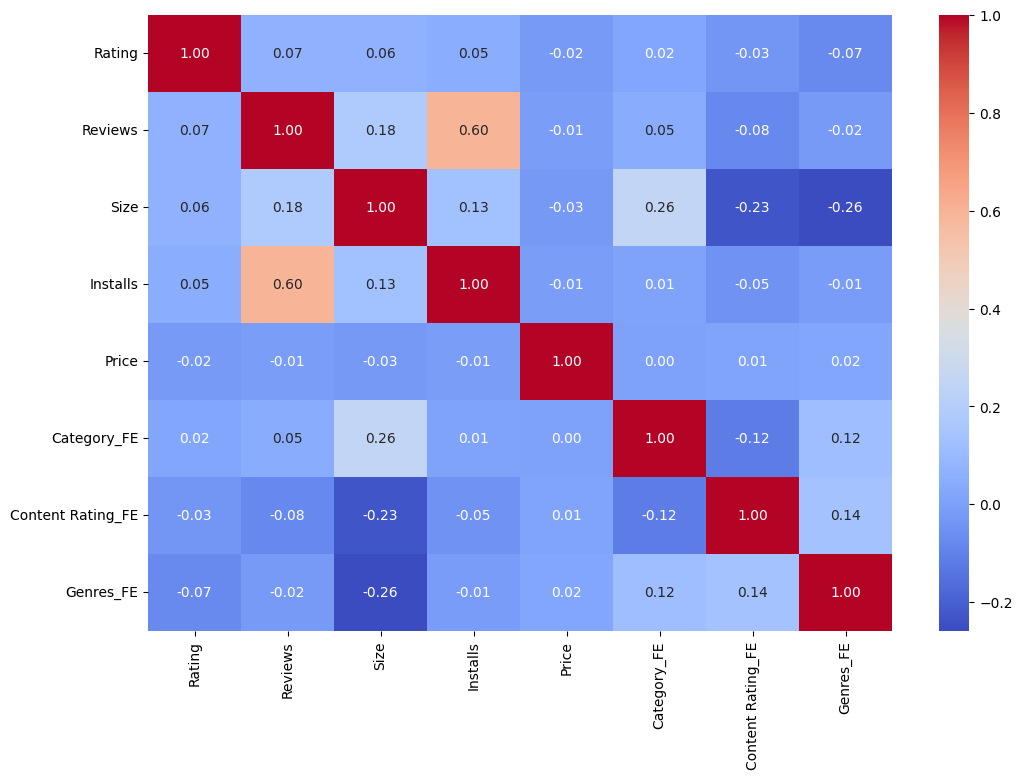

In [306]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()  # Calculate correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")  # Create a heatmap with seaborn
plt.show()

### 4.3.1 Scatter Plots of numerical variables vs rating

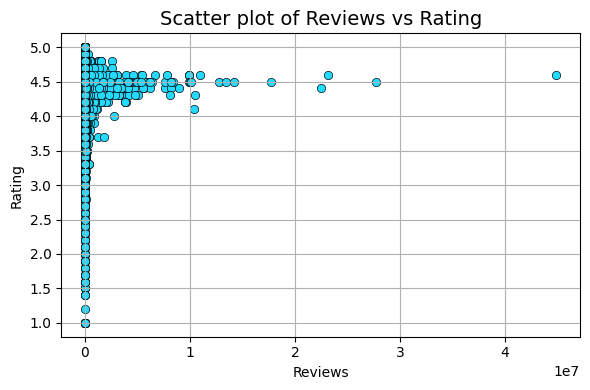

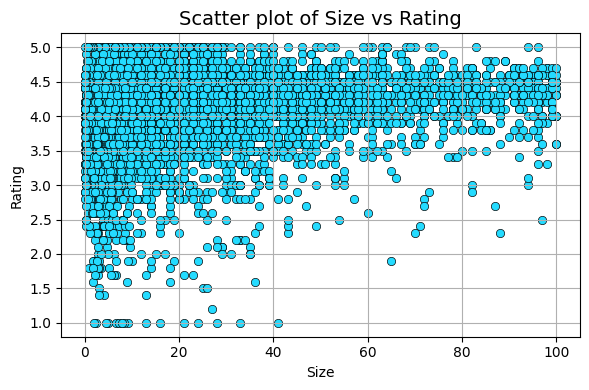

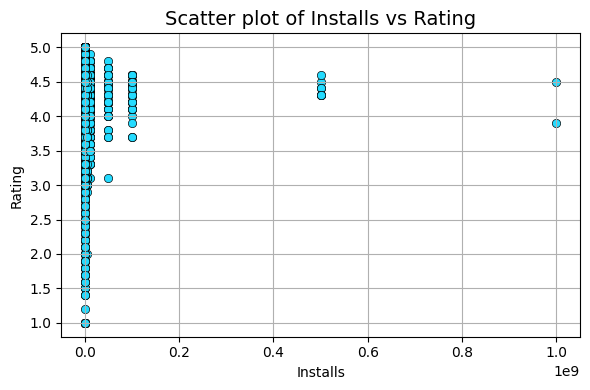

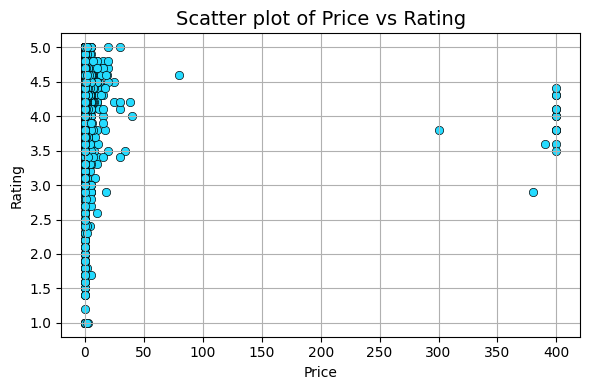

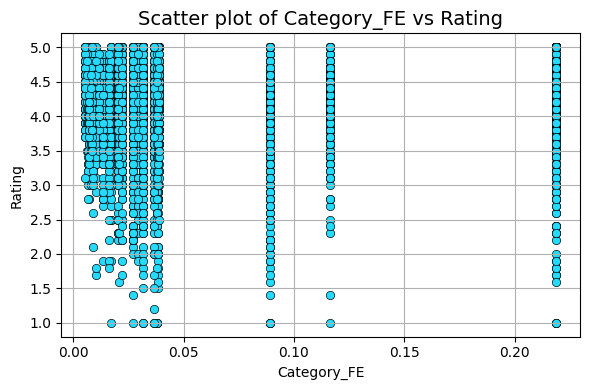

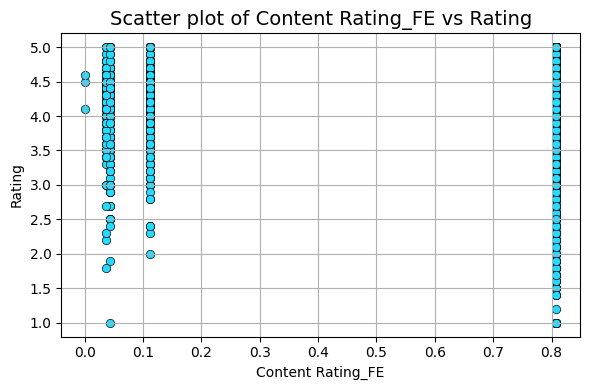

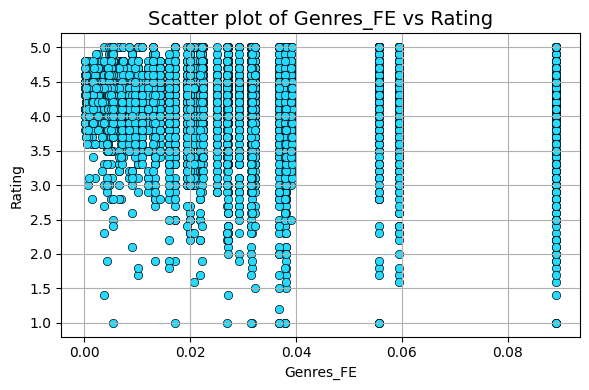

In [307]:
# Remove 'Rating' from the list of numeric columns
numeric_cols = numeric_cols.drop('Rating')

# Define a cool color palette
cool_palette = sns.color_palette("cool")

# Iterate over each numeric column
for col in numeric_cols:
    # Create a new figure with specified size
    plt.figure(figsize=(6, 4))
    
    # Scatter plot with custom aesthetics
    sns.scatterplot(x=col, y='Rating', data=df, color=cool_palette[0], edgecolor='k')
    
    # Set labels and title with custom font sizes
    plt.xlabel(col)
    plt.ylabel('Rating')
    plt.title(f'Scatter plot of {col} vs Rating', fontsize=14)
    
    # Add grid and adjust layout
    plt.grid(True)
    plt.tight_layout()
    
    # Show plot
    plt.show()

## 5 Check feature relevance for 'Reviews' and 'Installs'
4 different models in total.
1 with both 'Reviews' and 'Installs' as features
1 with only 'Reviews' as a feature
1 with only 'Installs' as a feature
1 with neither 'Reviews' nor 'Installs' as features

This for a regression model to predict 'Rating'
Also for a classification model to predict 'Rating' as Categorical (Excelent, Good, Bad etc.)

In [308]:
# Copy the DataFrame to avoid modifying the original data
data = df.copy()

# Convert 'Rating' column to categorical
data['Rating'] = pd.cut(data['Rating'], bins=[0, 2.9, 3.9, 4.9, 5.0], labels=['Bad', 'Good', 'Very Good', 'Excellent'])

# Model Building
X = data[['Reviews', 'Installs', 'Size', 'Price', 'Category_FE', 'Content Rating_FE', 'Genres_FE']]
y_regression = data['Rating']  # For regression task
y_classification = pd.Categorical(data['Rating']).codes  # For classification task

# Split data into training and testing sets with consistent random state
X_train, X_test, y_train_regression, y_test_regression = train_test_split(X, y_regression, test_size=0.2, random_state=42)
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X, y_classification, test_size=0.2, random_state=42)

# Encode the target variable for regression task using Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories=[['Bad', 'Good', 'Very Good', 'Excellent']])
y_train_regression_encoded = ordinal_encoder.fit_transform(y_train_regression.values.reshape(-1, 1)).flatten()
y_test_regression_encoded = ordinal_encoder.transform(y_test_regression.values.reshape(-1, 1)).flatten()

# Define models
regression_models = {
    "Both Features": RandomForestRegressor(),
    "Reviews Only": RandomForestRegressor(),
    "Installs Only": RandomForestRegressor(),
    "Neither": RandomForestRegressor()  # Model without both features
}

classification_models = {
    "Both Features": GradientBoostingClassifier(),
    "Reviews Only": GradientBoostingClassifier(),
    "Installs Only": GradientBoostingClassifier(),
    "Neither": GradientBoostingClassifier()  # Model without both features
}

# Train and evaluate regression models
for model_name, model in regression_models.items():
    if model_name == "Reviews Only":
        X_train_temp = X_train.drop(columns=['Installs'])
        X_test_temp = X_test.drop(columns=['Installs'])
    elif model_name == "Installs Only":
        X_train_temp = X_train.drop(columns=['Reviews'])
        X_test_temp = X_test.drop(columns=['Reviews'])
    elif model_name == "Neither":  # Case without both features
        X_train_temp = X_train.drop(columns=['Reviews', 'Installs'])
        X_test_temp = X_test.drop(columns=['Reviews', 'Installs'])
    else:
        X_train_temp = X_train
        X_test_temp = X_test

    model.fit(X_train_temp, y_train_regression_encoded)
    y_pred_regression = model.predict(X_test_temp)
    
    mse = mean_squared_error(y_test_regression_encoded, y_pred_regression)
    mae = mean_absolute_error(y_test_regression_encoded, y_pred_regression)
    r2 = r2_score(y_test_regression_encoded, y_pred_regression)
    explained_variance = explained_variance_score(y_test_regression_encoded, y_pred_regression)
    
    print(f"{model_name} Regression MSE: {mse}")
    print(f"{model_name} Regression MAE: {mae}")
    print(f"{model_name} Regression R-squared: {r2}")
    print(f"{model_name} Regression Explained Variance: {explained_variance}", end='\n\n')

# Train and evaluate classification models
for model_name, model in classification_models.items():
    if model_name == "Reviews Only":
        X_train_temp = X_train_classification.drop(columns=['Installs'])
        X_test_temp = X_test_classification.drop(columns=['Installs'])
    elif model_name == "Installs Only":
        X_train_temp = X_train_classification.drop(columns=['Reviews'])
        X_test_temp = X_test_classification.drop(columns=['Reviews'])
    elif model_name == "Neither":  # Case without both features
        X_train_temp = X_train_classification.drop(columns=['Reviews', 'Installs'])
        X_test_temp = X_test_classification.drop(columns=['Reviews', 'Installs'])
    else:
        X_train_temp = X_train_classification
        X_test_temp = X_test_classification

    model.fit(X_train_temp, y_train_classification)
    y_pred_classification = model.predict(X_test_temp)
    
    accuracy = accuracy_score(y_test_classification, y_pred_classification)
    precision = precision_score(y_test_classification, y_pred_classification, average='weighted')
    recall = recall_score(y_test_classification, y_pred_classification, average='weighted')
    f1 = f1_score(y_test_classification, y_pred_classification, average='weighted')
    
    print(f"{model_name} Classification Accuracy: {accuracy}")
    print(f"{model_name} Classification Precision: {precision}")
    print(f"{model_name} Classification Recall: {recall}")
    print(f"{model_name} Classification F1-score: {f1}", end='\n\n')


Both Features Regression MSE: 0.3185179111269389
Both Features Regression MAE: 0.40359567901234567
Both Features Regression R-squared: 0.06197134719159536
Both Features Regression Explained Variance: 0.06227125347269946

Reviews Only Regression MSE: 0.34545052637306106
Reviews Only Regression MAE: 0.41835814339981003
Reviews Only Regression R-squared: -0.01734464702217675
Reviews Only Regression Explained Variance: -0.017146396067143188

Installs Only Regression MSE: 0.3518689129678284
Installs Only Regression MAE: 0.42149899097815763
Installs Only Regression R-squared: -0.036246662640047944
Installs Only Regression Explained Variance: -0.03616423800792856

Neither Regression MSE: 0.4136192005674999
Neither Regression MAE: 0.4504549740749307
Neither Regression R-squared: -0.21809998097531458
Neither Regression Explained Variance: -0.21807329991074464

Both Features Classification Accuracy: 0.73005698005698
Both Features Classification Precision: 0.6476274037677546
Both Features Classif

## 6 Compare Regression, Classification and Clustering

Because our objective is to predict the rating of an app, we will use the dataset which had the best accuracy for the clasification model, which was the one without the 'Installs' feature, keeping the 'Reviews' feature.

### 6.1 Generating train and test datasets

In [309]:
# Model Building for Regression, Classification and Clustering
X = data[['Reviews', 'Installs', 'Size', 'Price', 'Category_FE', 'Content Rating_FE', 'Genres_FE']]
y_regression = data['Rating']  # For regression task
y_classification = pd.Categorical(data['Rating']).codes  # For classification task

### 6.2 Regression with Random Forest Regressor

In [310]:
# Split data into training and testing sets with consistent random state
X_train, X_test, y_train_regression, y_test_regression = train_test_split(X, y_regression, test_size=0.2, random_state=42)

# Encode the target variable for regression task using Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories=[['Bad', 'Good', 'Very Good', 'Excellent']])
y_train_regression_encoded = ordinal_encoder.fit_transform(y_train_regression.values.reshape(-1, 1)).flatten()
y_test_regression_encoded = ordinal_encoder.transform(y_test_regression.values.reshape(-1, 1)).flatten()

regression_model = RandomForestRegressor()
regression_model.fit(X_train, y_train_regression_encoded)

RandomForestRegressor()

### 6.3 Classification with Random Forest Classifier

In [311]:
# Split data into training and testing sets for classification task
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X, y_classification, test_size=0.2, random_state=42)

classification_model = GradientBoostingClassifier()
classification_model.fit(X_train_classification, y_train_classification)

GradientBoostingClassifier()

### 6.4 Clustering with DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

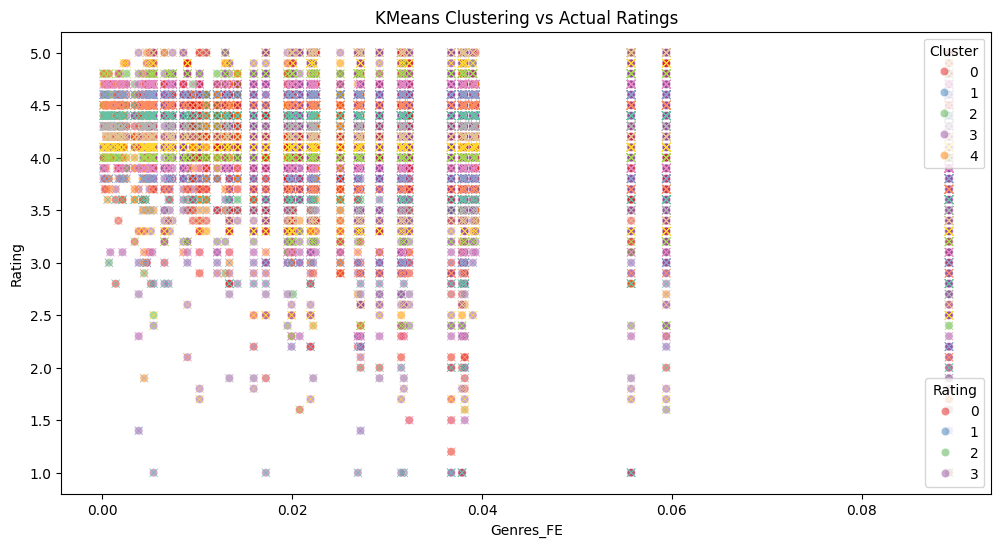

In [312]:
# Fit KMeans clustering algorithm
data = df.copy()
clustering_data = data[['Size', 'Price', 'Category_FE', 'Content Rating_FE', 'Genres_FE', 'Rating']]
# Change Rating to intervals and encode those intervals
clustering_data['Rating'] = pd.cut(clustering_data['Rating'], bins=[0, 2.9, 3.9, 4.9, 5.0], labels=['Bad', 'Good', 'Very Good', 'Excellent'])
clustering_data['Rating'] = ordinal_encoder.transform(clustering_data['Rating'].values.reshape(-1, 1)).flatten()

kmeans = KMeans(n_clusters=5).fit(clustering_data)

# Create a DataFrame to store the cluster labels
kmeans_dataset = data.copy().reset_index(drop=True)  # Reset index
kmeans_dataset.loc[:, 'Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(12, 6))

# Scatter plot for KMeans clusters
cluster_plot = sns.scatterplot(x='Genres_FE', y='Rating', hue='Cluster', data=kmeans_dataset, palette='Set1', alpha=0.5)

# Scatter plot for actual ratings (assuming 'Rating' is the column containing the actual ratings)
rating_plot = sns.scatterplot(x='Genres_FE', y='Rating', hue='Rating', data=kmeans_dataset, palette='Set2', marker='x')

plt.title('KMeans Clustering vs Actual Ratings')
plt.xlabel('Genres_FE')
plt.ylabel('Rating')

# Set legend for clusters
cluster_handles, _ = cluster_plot.get_legend_handles_labels()
cluster_legend = plt.legend(handles=cluster_handles[:5], title='Cluster', loc='upper right')

# Add legend for ratings
rating_handles, _ = rating_plot.get_legend_handles_labels()
rating_legend = plt.legend(handles=rating_handles[:4], title='Rating', loc='lower right')

# Display the plot with both legends
plt.gca().add_artist(cluster_legend)  # Add the cluster legend back to the plot
plt.show()


## 7 Train several models for either Regression or Classification (Test different algorithms)
Choose the 'dataset' with the best performance based on point 5.

## 8 Peform ANOVA (Analysis of Variance) on a trained model based on previous step

## 9 Conclusions